In [1]:
# basics
import numpy as np
import pandas as pd
import datetime
import re

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]

# own data wrappers
from imp import reload
import measureclass as mc; reload(mc);
import coronadataclass as cdc; reload(cdc);

np.seterr(divide = 'ignore');


In [2]:
# load data into datawrapper classes
measure_data = mc.COVID19_measures(download_data = True, measure_level = 2, only_first_dates = True, expand_measure_names = True)
jhu_data     = cdc.CoronaData(download_data = True)

In [3]:
# helper functions

def date2vector(implementdate, start = '22/1/20', end = None, shiftdays = 0):
    # generate vector of 0s and 1s when measure is implemented or not
    starttime     = datetime.datetime.strptime(start,         '%d/%m/%y')
    if end is None:
        endtime   = datetime.datetime.today()
    else:
        endtime   = datetime.datetime.strptime(end,           '%d/%m/%y')
    implementtime = datetime.datetime.strptime(implementdate, '%d/%m/%Y')
    
    totaldays   = (endtime       - starttime).days
    measuredays = (implementtime - starttime).days
    
    vec         = np.zeros(totaldays)
    vec[min(measuredays+shiftdays,len(vec)-1):] = 1
    
    return vec


def ConvertDateFormat(date):
    m,d,y = date.split('/')
    return '{:02d}/{:02d}/{:02d}'.format(int(d),int(m),int(y))



def LogCaseIncrease(df, key = 'Confirmed', mincases = None):
    cases             = np.array(df[key], dtype = np.int)
    if not mincases is None:
        restrict_date = np.argmin(cases >= mincases)
        cases         = cases[restrict_date:]
    else:
        restrict_date = 0
    ldcases           = np.log(np.diff(cases))

    return restrict_date, ldcases


def CleanUpMeasureName(measurename):
    # regression model formula can't contain special characters
    return ''.join([mn.capitalize() for mn in measurename.replace(',','').replace('-','').replace('/','').split(' ')])

In [43]:
def GetMeasureIDs(countrylist = None, measure_level = 2, mincount = None, extend_measure_names = False):
    if countrylist is None:
        countrylist = measure_data.countrylist # use ALL countries
    
    measurelist = {}
    
    # get all restrictions from countries
    for country in countrylist:
        country_measures = measure_data.CountryData(country, measure_level = 2, extend_measure_names = extend_measure_names)
        for measurename, initialdata in country_measures.items():
            if not measurename in measurelist.keys():
                measurelist[measurename] = 0
            measurelist[measurename] += 1
    
    if not mincount is None:
        # rebuild dict with restrictions
        measurelist = {k:v for k,v in measurelist.items() if v >= mincount}

    return measurelist


def SmoothTrajectories3(traj):
    if len(traj) > 3:
        newtraj       = np.zeros(len(traj))
        newtraj[0]    = (             2 * traj[0]    + traj[1]   )/3.
        newtraj[1:-2] = (traj[0:-3] + 2 * traj[1:-2] + traj[2:-1])/4.
        newtraj[-1]   = (traj[-2]   + 2 * traj[-1]               )/3.
        return newtraj
    else:
        return traj

def SmoothTrajectories5(traj):
    if len(traj) > 5:
        newtraj       = np.zeros(len(traj))
        newtraj[0]    = (                              3 * traj[0]    + 2 * traj[1]    + traj[2]   )/6.
        newtraj[1]    = (             2 * traj[0]    + 3 * traj[1]    + 2 * traj[2]    + traj[3]   )/8.
        newtraj[2:-3] = (traj[0:-5] + 2 * traj[1:-4] + 3 * traj[2:-3] + 2 * traj[3:-2] + traj[4:-1])/9.
        newtraj[-2]   = (traj[-4]   + 2 * traj[-3]   + 3 * traj[-2]   + 2 * traj[-1]               )/8.
        newtraj[-1]   = (traj[-3]   + 2 * traj[-2]   + 3 * traj[-1]                                )/6.
        return newtraj
    else:
        return SmoothTrajectories3(traj)
    

def GetCountryTrajectories(countrylist = None, data = 'Confirmed', startcases = None, maxlen = None, smooth = None):
    if countrylist is None:
        countrylist = jhu_data.countrylist
    
    trajectories = {}
    for country in [c for c in countrylist if c in jhu_data.countrylist]:
        ctraj = np.array(jhu_data.CountryData(country)[data], dtype = np.float)
        starttraj = 0
        if not startcases is None:
            starttraj = np.argmax(ctraj >= startcases)
            ctraj = ctraj[starttraj:]
            if not maxlen is None:
                ctraj = ctraj[:min(maxlen,len(ctraj))]
        trajectories[country] = {}
        if not smooth is None:
            smooth = 2 * int(smooth/2) + 1 # force odd, in case of even add 1
            sm2    = 2 * int(smooth/2)
            ctraj = np.convolve(ctraj,np.ones(smooth, dtype = np.float)/smooth, mode = 'full')[sm2:-sm2]
        trajectories[country]['traj'] = ctraj
        trajectories[country]['startdate'] = ConvertDateFormat(jhu_data.CountryData(country)['Date'][starttraj])
    
    return trajectories

        
def GetRegressionDF(countrylist = None, measure_level = 2, shiftdays = 0, verbose = False, maxlen = None, smooth = None):
    # construct pd.DataFrame used for regression
    
    # get trajectories and measure list for all countries in 'countrylist'
    trajectories         = GetCountryTrajectories(countrylist = countrylist, data = 'Confirmed', startcases = 20, maxlen = maxlen, smooth = smooth)
    measureIDs           = GetMeasureIDs(countrylist = countrylist, measure_level = 2, mincount = 5)
    cleaned_measurelist  = {CleanUpMeasureName(mn):count for mn,count in measureIDs.items()}
    regressionDF         = None
    
    if verbose:
        print(measureIDs)
    
    for country in trajectories.keys():
        if country in measure_data.countrylist:
            df_entry_dict               = {}
            df_entry_dict['Country']    = country
            
            # ********************************************
            # change observable to regress here:
            df_entry_dict['Observable'] = np.diff(np.log(trajectories[country]['traj']))
            # ********************************************
            
            if not (np.isnan(df_entry_dict['Observable']).any() or np.isinf(df_entry_dict['Observable']).any()):
                if verbose:
                    # print trajectories of individual countries for checking
                    print(country,df_entry_dict['Observable'])
                obslen                      = len(df_entry_dict['Observable'])
                df_entry_dict['Time']       = np.arange(obslen)

                for measurename in measureIDs.keys():
                    implementdate = measure_data.FindMeasure(country, measurename, measure_level)
                    if not implementdate is None:
                        vec = date2vector(implementdate = implementdate, start = trajectories[country]['startdate'], shiftdays = shiftdays)[:obslen]
                    else:
                        vec = np.zeros(obslen)
                    df_entry_dict[CleanUpMeasureName(measurename)] = vec

                if regressionDF is None:
                    regressionDF = pd.DataFrame(df_entry_dict)
                else:
                    regressionDF = regressionDF.append(pd.DataFrame(df_entry_dict))
    
    return regressionDF, cleaned_measurelist


def modelprediction(country, regrDF, fitparams):
    country_df = regrDF[regrDF['Country'] == country][:]
    pred = np.array(country_df['Intercept']) + (np.arange(len(country_df))+1) * np.array(country_df['Time'])
    for measure in fitparams.columns:
        if measure[:10] != 'C(Country)' and measure != 'Intercept' and measure != 'Time':
            pred += fitparams[measure] * np.array(country_df[measure])
    
    return pd.DataFrame({'Data' : np.array(country_df['Observable']), 'Model': pred})


def GetCountryMasks(regrDF):
    countrylist = list(regrDF['Country'].unique())
    maskdict = {}
    for country in countrylist:
        mask = list(regrDF['Country'] == country)
        maskdict[country] = mask
    return maskdict


[0.13515504 0.28937595 0.38333195 0.53736466 0.46438915 0.37414398
 0.2665263  0.27936106 0.3097959  0.32175351 0.31120389 0.29258242
 0.28481818 0.28119213 0.30163777 0.31478922 0.33826429 0.30320311
 0.27325844 0.22911017 0.22675098 0.21274798 0.20020219 0.18848096
 0.19337563 0.20377878 0.18915711 0.16768104 0.13892981 0.13308913
 0.11153582 0.0956347  0.07513866 0.07039664 0.06127463 0.05197876
 0.04057129 0.         0.02744075 0.02449479]
[0.         0.04505168 0.09010336 0.25722307 0.38333195 0.53736466
 0.46438915 0.37414398 0.2665263  0.27936106 0.3097959  0.32175351
 0.31120389 0.29258242 0.28481818 0.28119213 0.30163777 0.31478922
 0.33826429 0.30320311 0.27325844 0.22911017 0.22675098 0.21274798
 0.20020219 0.18848096 0.19337563 0.20377878 0.18915711 0.16768104
 0.13892981 0.13308913 0.11153582 0.0956347  0.07513866 0.07039664
 0.06127463 0.05197876 0.04057129 0.03320188 0.02439177 0.01632986
 0.00748616 0.00251773]
[0.08109302 0.30081548 0.38918203 0.43944492 0.38918203 0.4

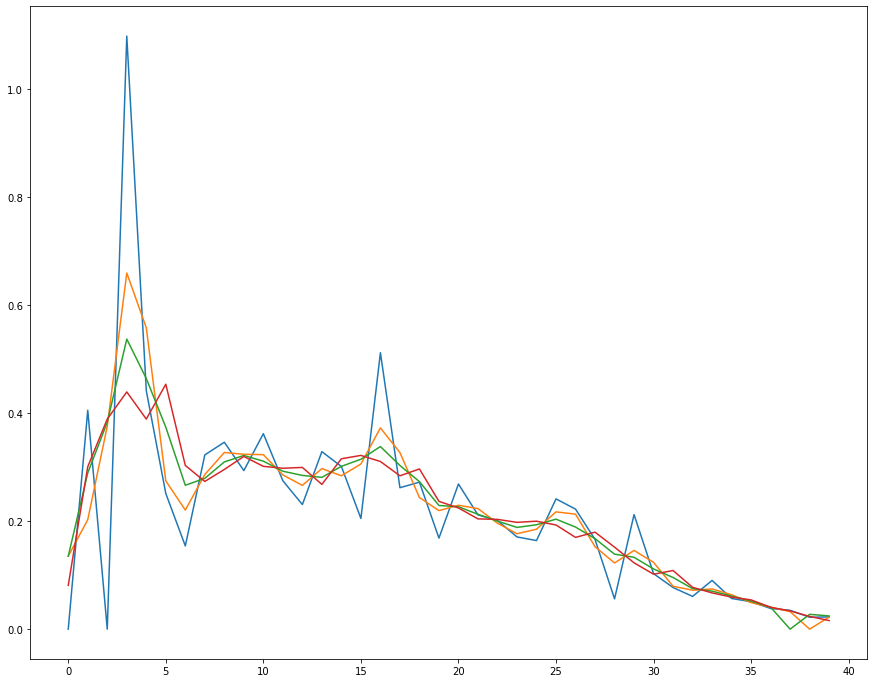

In [44]:
x = np.random.random(20)


ta = GetCountryTrajectories(['Austria'])
#plt.plot(ta['Austria']['traj'])

confc = ta['Austria']['traj']
confc = confc[confc > 0]
dlc = np.log(confc[1:]/confc[:-1])

sm5 = np.convolve(dlc,np.array([1,2,3,2,1])/9.,mode = 'full')
sm5_1 = np.convolve(dlc,np.ones(5)/5., mode = 'full')[2:-2]

print(SmoothTrajectories5(dlc))
print(sm5)
print(sm5_1)
plt.plot(dlc)
plt.plot(SmoothTrajectories3(dlc))
plt.plot(SmoothTrajectories5(dlc))
plt.plot(sm5_1)

smooth = 6


print(2 * int(smooth/2) + 1)


In [45]:
# generate regression dicts

maxshift = 10
regrDF40_1 = []
regrDF40_3 = []
regrDF40_5 = []

for shiftdays in np.arange(0,maxshift + 1):
    print(shiftdays)

    tmp,ml = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, maxlen = 40)
    regrDF40_1.append(tmp)

    tmp,ml = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, maxlen = 40, smooth = 3)
    regrDF40_3.append(tmp)
    
    tmp,ml = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, maxlen = 40, smooth = 5)
    regrDF40_5.append(tmp)
    

0


/home/lukas/projects/corona/programs/measureclass.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countrydata['Measure_L{:d}'.format(ml)] = countrydata['Measure_L{:d}'.format(ml)].fillna(countrydata['Measure_L{:d}'.format(ml-1)])
/home/lukas/projects/corona/programs/measureclass.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countrydata['MN'] = countrydata['Measure_L{:d}'.format(measure_level)]
/usr/lib64/python3.7/site-packages/numpy/lib/function_base.py:1273: RuntimeWarning: invalid value encoun

1
2
3
4
5
6
7
8
9
10


In [47]:


# regression and store everything
maxshift = 10

# store all input and output

r2_results     = None
param_results  = None

for shiftdays in np.arange(0,maxshift + 1):
    # generate all data into pandas DF for regression
    # regrDF,ml = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays)

    # model formula
    formula = 'Observable ~ Time + C(Country) + ' + ' + '.join(ml)

    # regression with Ordinary Least Squares (OLS)
    model1   = smf.ols(formula = formula, data = regrDF40_1[shiftdays])
    model3   = smf.ols(formula = formula, data = regrDF40_3[shiftdays])
    model5   = smf.ols(formula = formula, data = regrDF40_5[shiftdays])
    
    for alphae in range(-6,3):
        print(shiftdays,alphae)

        results1 = model1.fit_regularized(method = 'elastic_net', alpha = 10**alphae, L1_wt = 1)
        results3 = model3.fit_regularized(method = 'elastic_net', alpha = 10**alphae, L1_wt = 1)
        results5 = model5.fit_regularized(method = 'elastic_net', alpha = 10**alphae, L1_wt = 1)

        regrDF40_1[shiftdays]['pred_EN{}'.format(alphae)] = results1.predict()
        regrDF40_3[shiftdays]['pred_EN{}'.format(alphae)] = results3.predict()
        regrDF40_5[shiftdays]['pred_EN{}'.format(alphae)] = results5.predict()
        
        obs_1 = np.array(regrDF40_1[shiftdays]['Observable'])
        obs_3 = np.array(regrDF40_3[shiftdays]['Observable'])
        obs_5 = np.array(regrDF40_5[shiftdays]['Observable'])
        
        r2_1 = 1 - np.sum((obs_1 - results1.predict())**2)/np.sum((obs_1 - np.mean(obs_1))**2)
        r2_3 = 1 - np.sum((obs_3 - results3.predict())**2)/np.sum((obs_3 - np.mean(obs_3))**2)
        r2_5 = 1 - np.sum((obs_5 - results5.predict())**2)/np.sum((obs_5 - np.mean(obs_5))**2)
        
        cur_res_1 = {'shiftdays':shiftdays,'alphae':alphae,'smooth': 1,'r2':r2_1}
        cur_res_3 = {'shiftdays':shiftdays,'alphae':alphae,'smooth': 3,'r2':r2_3}
        cur_res_5 = {'shiftdays':shiftdays,'alphae':alphae,'smooth': 5,'r2':r2_5}

        if r2_results is None:
            r2_results = pd.DataFrame({k:np.array([v]) for k,v in cur_res_1.items()})
        else:
            r2_results = r2_results.append(cur_res_1, ignore_index = True)
        r2_results = r2_results.append(cur_res_3, ignore_index = True)
        r2_results = r2_results.append(cur_res_5, ignore_index = True)

        cur_params_1 = {'shiftdays':shiftdays,'alphae':alphae, 'smooth': 1, 'params':results1.params}
        cur_params_3 = {'shiftdays':shiftdays,'alphae':alphae, 'smooth': 1, 'params':results3.params}
        cur_params_5 = {'shiftdays':shiftdays,'alphae':alphae, 'smooth': 1, 'params':results5.params}
        
        if param_results is None:
            param_results = pd.DataFrame({k:np.array(v) for k,v in cur_params_1.items()})
        else:
            param_results.append(cur_params_1, ignore_index = True)
        param_results.append(cur_params_3, ignore_index = True)
        param_results.append(cur_params_3, ignore_index = True)

        
    #print(results.params)
    #print(results.llf)
    #results.save(fname = 'output_{}.txt'.format(shiftdays))
    # output

    # print(results.summary())
    
    #filename = 'regression_shiftdays{}_glm.csv'.format(shiftdays)

    #def dropheaderlines(csv_string, droplines = 10):
    #    return '\n'.join(csv_string.split('\n')[droplines:]),'\n'.join(csv_string.split('\n')[:droplines])

    #csv_table = results.summary().as_csv()

    #fp = open(filename,'w')
    #csv_data, glm_header= dropheaderlines(csv_table)
    #fp.write(csv_data)
    #fp.close()

    #readdata = pd.read_csv(filename)
    #print('shiftdays = {}'.format(shiftdays))
    #print(readdata[readdata['P>|z| '] < 0.05].sort_values(by = 'P>|z| ')[['                                               ', '   coef   ','P>|z| ']])
    #print()
    
    #input_df_glm.append(regrDF)
    #summary_df_glm.append(readdata)
    #measures_glm.append(ml)
    #header_glm.append(glm_header)
#print(r2_results40_5)

0 -6
0 -5
0 -4
0 -3
0 -2
0 -1
0 0
0 1
0 2
1 -6
1 -5
1 -4
1 -3
1 -2
1 -1
1 0
1 1
1 2
2 -6
2 -5
2 -4
2 -3
2 -2
2 -1
2 0
2 1
2 2
3 -6
3 -5
3 -4
3 -3
3 -2
3 -1
3 0
3 1
3 2
4 -6
4 -5
4 -4
4 -3
4 -2
4 -1
4 0
4 1
4 2
5 -6
5 -5
5 -4
5 -3
5 -2
5 -1
5 0
5 1
5 2
6 -6
6 -5
6 -4
6 -3
6 -2
6 -1
6 0
6 1
6 2
7 -6
7 -5
7 -4
7 -3
7 -2
7 -1
7 0
7 1
7 2
8 -6
8 -5
8 -4
8 -3
8 -2
8 -1
8 0
8 1
8 2
9 -6
9 -5
9 -4
9 -3
9 -2
9 -1
9 0
9 1
9 2
10 -6
10 -5
10 -4
10 -3
10 -2
10 -1
10 0
10 1
10 2


IndexError: Item wrong length 1220 instead of 1134.

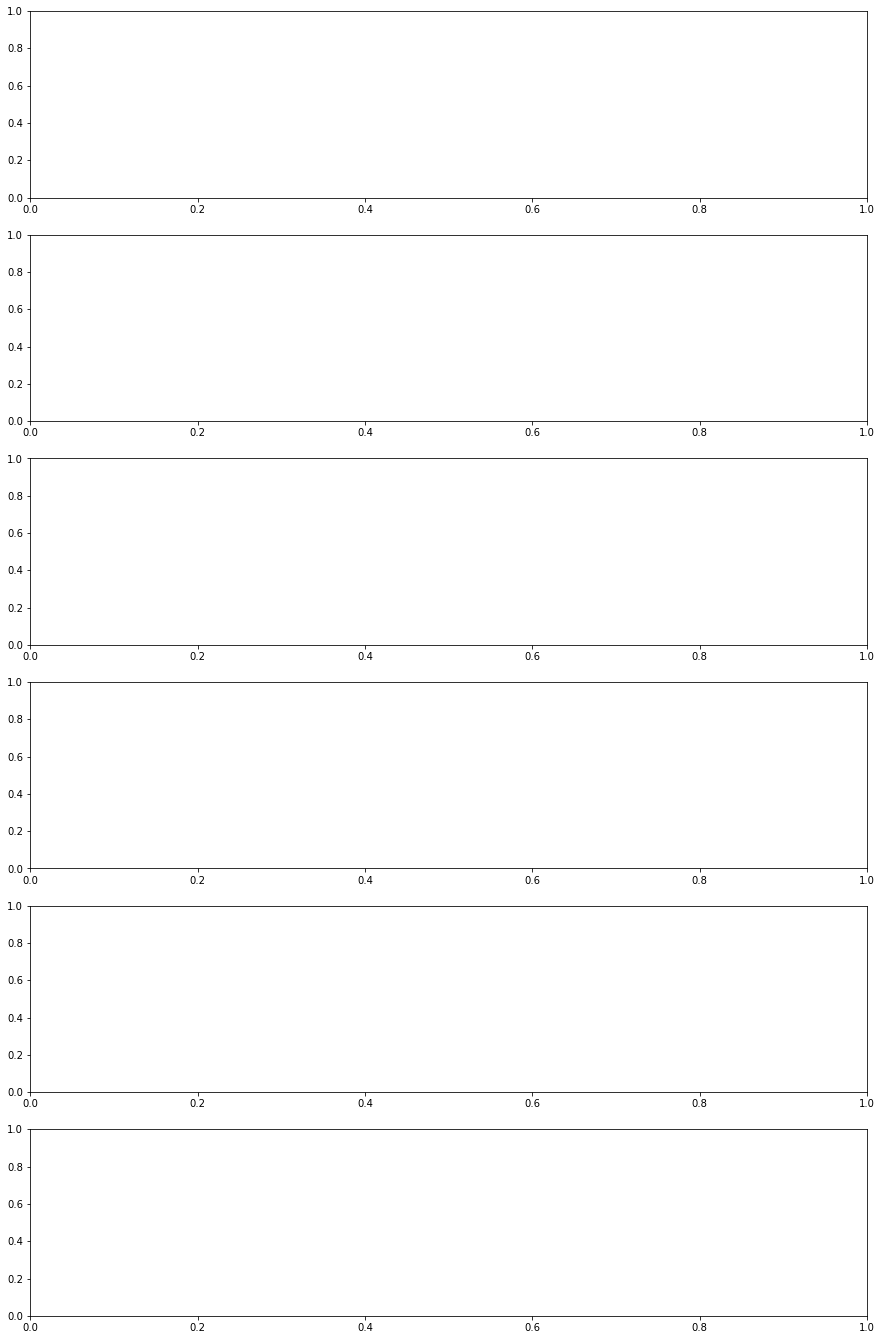

In [49]:
specialcountries = ['Austria','Germany', 'Italy', 'Spain', 'Japan', 'United Kingdom']
cm               = GetCountryMasks(regrDF40_1[0])

fig,ax = plt.subplots(len(specialcountries),1,figsize = (15,4 * len(specialcountries)))

for i,country in enumerate(specialcountries):
    countryobs1 = np.array(regrDF40_1[0]['Observable'][cm[country]])
    #countryobs3 = np.array(regrDF40_3[0]['Observable'][cm[country]])
    #countryobs5 = np.array(regrDF40_5[0]['Observable'][cm[country]])
    #ax[i].plot(countryobs1, label = 'Observation', lw = 5, zorder = 100)
    #ax[i].plot(countryobs3, label = 'Observation', lw = 5, zorder = 100)
    ax[i].plot(countryobs5, label = 'Observation', lw = 5, zorder = 100)

    #for shiftdays in np.arange(maxshift+1):
    #    curpred1 = np.array(regrDF40_1[shiftdays]['pred{}'.format(alphae)][cm[country]])
    #    curpred3 = np.array(regrDF40_3[shiftdays]['pred{}'.format(alphae)][cm[country]])
    #    curpred5 = np.array(regrDF40_5[shiftdays]['pred{}'.format(alphae)][cm[country]])
    #    ax[i].plot(curpred1, zorder = 20 + alphae)
    #    ax[i].plot(curpred3, zorder = 20 + alphae)
    #    ax[i].plot(curpred5, zorder = 20 + alphae)
    #    for alphae in range(-6,2):
    #        #curpred1 = np.array(regrDF40_1[shiftdays]['pred_EN{}'.format(alphae)][cm[country]])
    #        #curpred3 = np.array(regrDF40_3[shiftdays]['pred_EN{}'.format(alphae)][cm[country]])
    #        #curpred5 = np.array(regrDF40_5[shiftdays]['pred_EN{}'.format(alphae)][cm[country]])
    #        #ax[i].plot(curpred1, zorder = 20 + alphae)
    #        #ax[i].plot(curpred3, zorder = 20 + alphae)
    #        #ax[i].plot(curpred5, zorder = 20 + alphae)
    #        continue
    ax[i].set_title(country, fontsize = 20)
    ax[i].set_ylim([-.2,1])
    ax[i].set_xlim([0,40])
    ax[i].grid()
fig.tight_layout()


In [83]:
o1 = np.array(regrDF40_1[0]['Observable'])
o3 = np.array(regrDF40_3[0]['Observable'])
o5 = np.array(regrDF40_5[0]['Observable'])

print(0.25*(o1[1:-3] + 2*o1[2:-2] + o1[3:-1]))
print(o3[2:-2])
#print(o5)

#plt.plot(o1)
#plt.plot(o3)
#plt.plot(o5)

TypeError: 'NoneType' object is not subscriptable

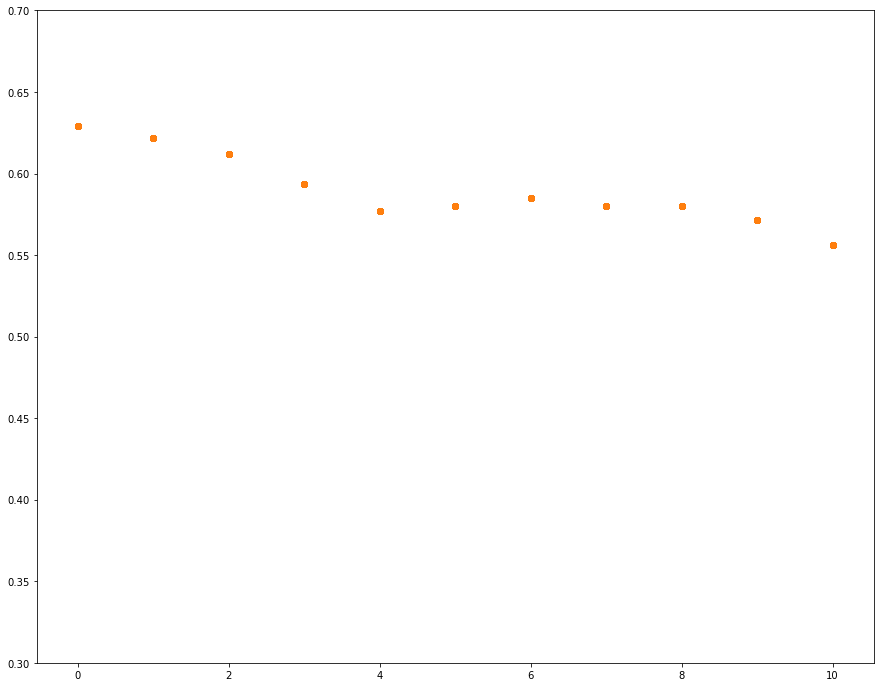

In [59]:
plt.scatter(r2_results['shiftdays'],r2_results['r2'])
plt.scatter(r2_results40_5['shiftdays'],r2_results40_5['r2'])
plt.ylim([.3,.7])
plt.show()

['Albania' 'Austria' 'Belgium' 'Bosnia and Herzegovina' 'Canada' 'Croatia'
 'Denmark' 'Diamond Princess' 'Ecuador' 'Estonia' 'Finland' 'Germany'
 'Iceland' 'Indonesia' 'Italy' 'Kuwait' 'Liechtenstein' 'Lithuania'
 'Malaysia' 'Mexico' 'Montenegro' 'Netherlands' 'Norway' 'Portugal'
 'Romania' 'Serbia' 'Singapore' 'Slovakia' 'Spain' 'Sweden' 'Switzerland'
 'Thailand' 'United Kingdom' 'New Zealand' 'Japan' 'Honduras' 'Kazakhstan'
 'Greece' 'North Macedonia' 'Kosovo' 'Brazil' 'India' 'Hungary']


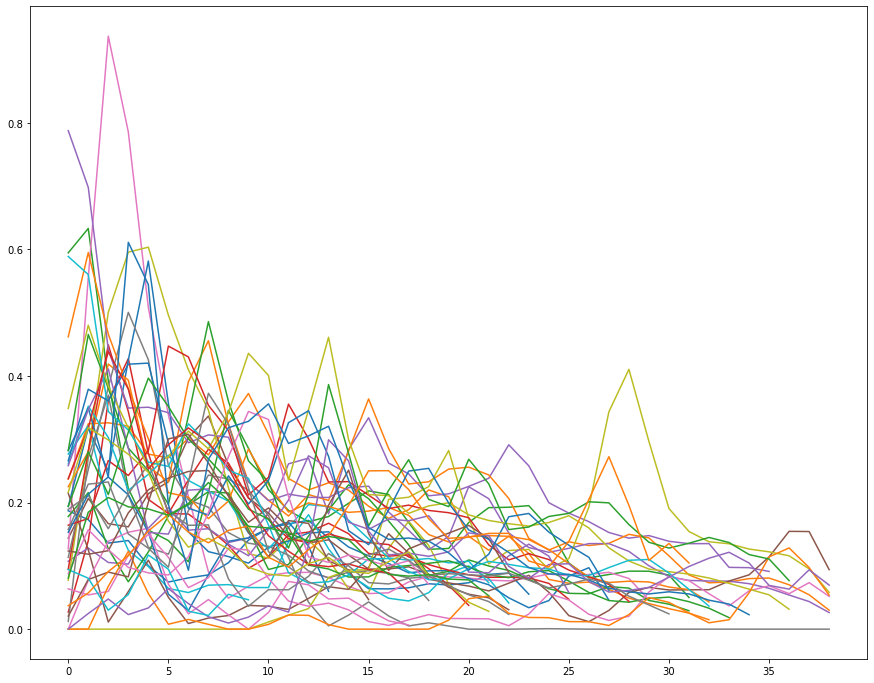

In [62]:
allcountries = regrDF[0]['Country'].unique()
print(allcountries)

for country in allcountries:
    plt.plot(regrDF30[0]['Observable'][cm[country]])
plt.show()


In [ ]:
# graphical output

def getPvalue(shiftdays = 0, country = None, key = None, measure = None):
    if not country is None:
        dfkey = '{:47s}'.format('C(Country)[T.' + country + ']')
    elif not key is None:
        dfkey = '{:47s}'.format(key)
    elif not measure is None:
        dfkey = '{:47s}'.format(measure)
    plist = summary_df_glm[shiftdays][summary_df_glm[shiftdays]['{:47s}'.format('')] == dfkey]['P>|z| ']
    return np.float(plist)
            
def p2color(p):
    if p < 0.05:
        return 'black'
    else:
        return 'lightgray'

# collect measure names for labels
ml = GetMeasureIDs(measure_level = 2,mincount = 5, extend_measure_names=True)
measure_level_dict = {}
for mn in ml.keys():
    l1,l2 = mn.split(' - ')
    if not l1 in measure_level_dict.keys():
        measure_level_dict[l1] = {}
    measure_level_dict[l1][l2] = CleanUpMeasureName(l2)

# collect all countries
countrylist = [name[13:].split(']')[0] for name in summary_df_glm[0]['                                               '] if name[:4] == 'C(Co']

# start plotting
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]
fig,ax = plt.subplots(figsize = (20,30))

label_x      = 1
label_dy     = 1
label_yshift = -.15
plot_x       = 8
plot_dx      = 1

pointsize    = 120
boxalpha     = .08
maxshift     = 10


for shiftdays in np.arange(maxshift + 1):
    groupcolor = 0
    # plot intercept and time effects
    if shiftdays == 0:
        ax.annotate('Intercept', (label_x,     1 * label_dy + label_yshift), c = colornames[groupcolor])
        ax.annotate('Time',      (label_x,     2 * label_dy + label_yshift), c = colornames[groupcolor])
        ax.annotate('Linear Fit',(label_x -.2, 3 * label_dy + label_yshift), c = colornames[groupcolor], weight = 'bold')
        
        background = plt.Rectangle([label_x - .5, .35], plot_x + maxshift + 1 - label_x, 3 + .8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
        ax.add_patch(background)
    
    pval_intercept = getPvalue(shiftdays, key = 'Intercept')
    pval_time      = getPvalue(shiftdays, key = 'Time')
    
    ax.scatter([plot_x + shiftdays],[1 * label_dy], c = p2color(pval_intercept), s = pointsize)
    ax.scatter([plot_x + shiftdays],[2 * label_dy], c = p2color(pval_time),      s = pointsize)
    
    
    # plot country effects
    groupcolor = 1
    i = 5
    if shiftdays == 0:
        background = plt.Rectangle([label_x - .5, i - .65], plot_x + maxshift + 1 - label_x, len(countrylist) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
        ax.add_patch(background)
        ax.annotate('Effects within individual countries', [label_x - .2, i * label_dy + len(countrylist)], c = colornames[groupcolor], weight = 'bold')
        
    for country in countrylist[::-1]:
        if shiftdays == 0:
            ax.annotate(country, (label_x, i * label_dy + label_yshift), c = colornames[groupcolor])
        
        pval_country = getPvalue(shiftdays, country = country)
        ax.scatter([plot_x + shiftdays],[i * label_dy], c = p2color(pval_country), s = pointsize)
        
        
        i += 1
    
    
    l1keys = list(measure_level_dict.keys())
    l1keys.sort()
    
    # plot measures effects
    for l1key in l1keys[::-1]:
        groupcolor += 1
        i += 2
        l2keys = list(measure_level_dict[l1key].keys())
        l2keys.sort()
        
        if shiftdays == 0:
            background = plt.Rectangle([label_x - .5, i - .65], plot_x + maxshift + 1 - label_x, len(measure_level_dict[l1key]) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
            ax.add_patch(background)
            ax.annotate(l1key, [label_x - .2, (i + len(measure_level_dict[l1key]))*label_dy + label_yshift], c = colornames[groupcolor], weight = 'bold')
            
        for l2key in l2keys[::-1]:
            if shiftdays == 0:
                count_countries = measures_glm[shiftdays][measure_level_dict[l1key][l2key]]
                active_days = np.array(input_df_glm[shiftdays][measure_level_dict[l1key][l2key]])
                fraction_active =  np.sum(active_days)/len(active_days)
                ax.annotate('{}'.format(l2key),[label_x, i*label_dy + label_yshift], c = colornames[groupcolor])
                ax.annotate('{:d}'.format(count_countries) ,[plot_x - 1.8, i*label_dy + label_yshift], c = colornames[groupcolor])
                ax.annotate('{:.4f}'.format(fraction_active),[plot_x - 1, i*label_dy + label_yshift], c = colornames[groupcolor])
            pval_measure = getPvalue(shiftdays, measure = measure_level_dict[l1key][l2key])
            ax.scatter([plot_x + shiftdays],[i * label_dy], c = p2color(pval_measure), s = pointsize)
            i += 1
    ax.axes.set_xlim([0,18])
    ax.annotate('{}'.format(shiftdays),[plot_x + shiftdays,(i+2)*label_dy + label_yshift])

ax.annotate('Shift Effects by Days:', [label_x, (i+2) * label_dy + label_yshift])
ax.axis('off')
#fig.show()
plt.savefig('regression_measures_glm.pdf')

In [ ]:
print(countrylist)